# Рубежный контроль №2. Тема: Методы построения моделей машинного обучения.

Выполнил:

студент группы РТ5-61Б Пакало Александр Сергеевич

В качестве [датасета](https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv) набор данных домов для аренды в разных городах Бразилии. Стоит задача предсказать финальную стоимость аренды, т.е. решается задача регрессии.

## Импорт библиотек

Импортируем необходимые для выполнения работы библиотеки

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
pd.options.display.float_format = '{:.0f}'.format

## Загрузка данных

Прочитаем имеющийся набора данных в переменную

In [5]:
data = pd.read_csv('data/houses_to_rent_v2.csv')

Выведем основую информацию и статистические показатели по датасету

In [6]:
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [8]:
data.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692,10692,10692,10692,10692,10692,10692,10692,10692
mean,149,3,2,2,1174,3896,367,53,5490
std,537,1,1,2,15592,3409,3108,48,16485
min,11,1,1,0,0,450,0,3,499
25%,56,2,1,0,170,1530,38,21,2062
50%,90,2,2,1,560,2661,125,36,3582
75%,182,3,3,2,1238,5000,375,68,6768
max,46335,13,10,12,1117000,45000,313700,677,1120000


<AxesSubplot:>

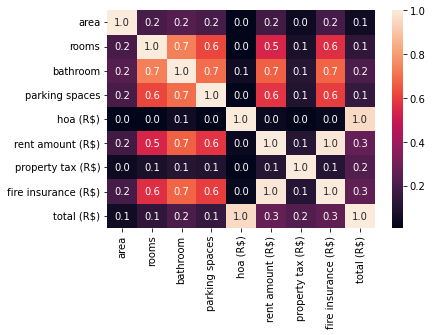

In [9]:
sns.heatmap(data.corr(), annot=True, fmt='.1f')

Согласно полученной документации мы имеем датасет из 13 колонок и 10692 строк:

**Признаки**
- `city` - город, в котором расположена квартира
- `area` - площадь квартиры
- `rooms` - количество комнат в квартире
- `bathroom` - количество ванных комнат
- `parking spaces` - количество парковочных мест
- `floor` - этаж, на котором расположена квартира
- `animal` - разрешение на проживание с домашним животным
- `furniture` - мебель
- `hoa` - налог на товарищество собственников жилья
- `rent amount` - размер арендной платы
- `property tax` - налог на имущество
- `fire insurance` - страховка от пожара

**Целевая переменная**
- `total` - суммарная стоимость аренды

В данных остутствуют явные пропуски, однако о качестве данных все же известно мало, поэтому потребуется предобработка.

## Предобработка данных

### Переименование столбцов

In [10]:
data.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [11]:
data = data.rename(columns={'hoa (R$)':'hoa',
                            'rent amount (R$)':'rent_amount',
                            'property tax (R$)':'property_tax',
                            'fire insurance (R$)' : 'fire_insurance',
                            'total (R$)' : 'total',
                            'parking spaces' : 'parking_spaces'})

### Обработка пропусков

В блоке информации по всему датасету можно заметить, что параметр floor имеет тип данных **object**, а по своему смыслу хранит целочисленные значения, видимо внутри есть пропуски, заполненные "заглушками", которые не позволяют определеить верный тип хранимых данных.

In [12]:
data['floor'].value_counts()

-      2461
1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

Так и есть, значений, заполненных "заглушкой" в виде **-** почти 25% датасета. Видимо при сборе данных некоторые пользователи не указали этаж и на этом месте появилась заглушка, или же опрос проводили несколько раз, и поле с номером этажа было не всегда.

<AxesSubplot:>

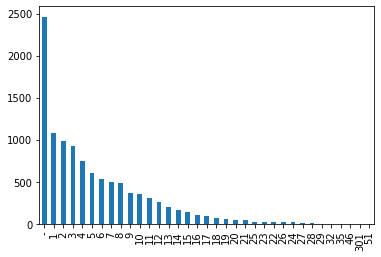

In [13]:
data['floor'].value_counts().plot(kind='bar')

<AxesSubplot:>

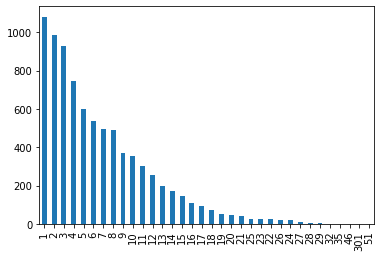

In [14]:
data.query('floor != "-"')['floor'].value_counts().plot(kind='bar')

In [15]:
data.query('floor != "-"')['floor'].median()

5.0

Заполнять медианным и средним нельзя, это сильно исказит исходное распределение, поэтому уберем эти записи из нашего датасета, чтобы не повредить качество обработанных данных.

In [16]:
data = data.query('floor != "-"').reset_index(drop=True)
data = data.astype({'floor':'int32'})

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231 entries, 0 to 8230
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            8231 non-null   object
 1   area            8231 non-null   int64 
 2   rooms           8231 non-null   int64 
 3   bathroom        8231 non-null   int64 
 4   parking_spaces  8231 non-null   int64 
 5   floor           8231 non-null   int32 
 6   animal          8231 non-null   object
 7   furniture       8231 non-null   object
 8   hoa             8231 non-null   int64 
 9   rent_amount     8231 non-null   int64 
 10  property_tax    8231 non-null   int64 
 11  fire_insurance  8231 non-null   int64 
 12  total           8231 non-null   int64 
dtypes: int32(1), int64(9), object(3)
memory usage: 803.9+ KB


### Кодирование категориальных признаков

Закодируем категориальные признаки с помощью техники One-Hot Encoding

In [18]:
data_ohe = pd.get_dummies(data, columns=['city', 'animal', 'furniture'], drop_first=1)

In [19]:
data_ohe

,area,rooms,bathroom,parking_spaces,floor,hoa,rent_amount,property_tax,fire_insurance,total,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,animal_not acept,furniture_not furnished
0,70,2,1,1,7,2065,3300,211,42,5618,0,0,0,1,0,0
1,320,4,4,0,20,1200,4960,1750,63,7973,0,0,0,1,0,1
2,80,1,1,1,6,1000,2800,0,41,3841,0,1,0,0,0,1
3,51,2,1,0,2,270,1112,22,17,1421,0,1,0,0,0,1
4,25,1,1,0,1,0,800,25,11,836,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226,150,3,3,2,8,0,13500,0,172,13670,0,0,0,1,1,0
8227,63,2,1,1,5,402,1478,24,22,1926,0,1,0,0,1,0
8228,285,4,4,4,17,3100,15000,973,191,19260,0,0,0,1,0,1
8229,70,3,3,0,8,980,6000,332,78,7390,0,0,1,0,1,0


## Разделение данных на обучающую и тестовую выборки

Выделим из датасета целевой признак и параметры, также исключим из датасета те столбцы, которые сильно коррелируют между собой

In [20]:
features = data_ohe.drop(['total', 'rent_amount', 'bathroom'], axis=1)
target = data_ohe['total']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                             target,
                                                                             test_size=0.25,
                                                                             random_state=1)

In [22]:
print(features_train.shape, features_test.shape)

(6173, 13) (2058, 13)


In [23]:
print(target_train.shape, target_test.shape)

(6173,) (2058,)


## Обучение моделей

### Обучение модели решающего дерева

In [24]:
model_DT = DecisionTreeRegressor(random_state=1, max_depth=10)

In [25]:
%%time
model_DT.fit(features_train, target_train)

CPU times: user 21.1 ms, sys: 92 µs, total: 21.2 ms
Wall time: 21 ms


DecisionTreeRegressor(max_depth=10, random_state=1)

In [26]:
predictions_DT = model_DT.predict(features_test)

In [27]:
print('Decision Tree:', mean_absolute_error(target_test, predictions_DT))

Decision Tree: 332.5153566973952


### Обучение модели градиентного бустинга

In [28]:
model = XGBRegressor(objective='reg:squarederror')

In [29]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, features, target, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

In [30]:
print('MAE (Средняя Абсолютная Ошибка): %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE (Средняя Абсолютная Ошибка): -181.386 (126.665)


In [31]:
model = XGBRegressor(objective='reg:squarederror')

In [32]:
%%time
model.fit(features_train, target_train)

CPU times: user 2.82 s, sys: 216 ms, total: 3.03 s
Wall time: 915 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [33]:
predictions_GB = model.predict(features_test)

In [34]:
print('Gradient boosting:', mean_absolute_error(target_test, predictions_GB))

Gradient boosting: 137.5728101368896


## Подбор гиперпараметров

### Гиперпараметры модели дерева решений

In [35]:
n_range = np.array(range(1, 41, 2))
tuned_parametrs = [{'max_depth' : n_range}]
tuned_parametrs

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39])}]

In [36]:
%%time

tuned_DT = GridSearchCV(DecisionTreeRegressor(random_state=1), tuned_parametrs, cv=5, scoring='neg_mean_absolute_error')
tuned_DT.fit(features, target)

CPU times: user 3.71 s, sys: 0 ns, total: 3.71 s
Wall time: 3.71 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
             param_grid=[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])}],
             scoring='neg_mean_absolute_error')

In [37]:
tuned_DT.best_params_

{'max_depth': 27}

### Гиперпараметры модели градиентного бустинга

In [38]:
param_test = {
'gamma':[0, 0.3, 0.4, 0.5],
'subsample':[0, 0.3, 0.5, 0.7, 0.9],
'reg_lambda':[1,5,10],
'max_depth':[1, 3, 5],
'colsample_bytree' : [0.2, 0.4, 0.8, 1]}

In [ ]:
%%time

tuned_GB = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid = param_test, scoring='neg_mean_squared_error', cv=5 )
tuned_GB.fit(features, target)

In [ ]:
tuned_GB.best_params_

### Обучение оптимальных моделей

#### Дерево решений

In [ ]:
tuned_DT.best_estimator_.fit(features_train, target_train)

In [ ]:
predictions_DT_tuned_train = tuned_DT.best_estimator_.predict(features_train)
predictions_DT_tuned_test = tuned_DT.best_estimator_.predict(features_test)

#### Градиентный бустинг

In [ ]:
tuned_GB.best_estimator_.fit(features_train, target_train)

In [ ]:
predictions_GB_tuned_train = tuned_GB.best_estimator_.predict(features_train)
predictions_GB_tuned_test = tuned_GB.best_estimator_.predict(features_test)

## Оценка качества полученных моделей

Для оценки качестве полученных моделей использовались стандартные метрики качества для задачи регрессии: MAE, MSE, RMSE, R2.

In [ ]:
mae_dict = {}
mse_dict = {}
rmse_dict = {}
r2_dict = {}

In [ ]:
mae_dict = {'Gradient boosting' : mean_absolute_error(target_test, predictions_GB_tuned_test),
            'Decision Tree' : mean_absolute_error(target_test, predictions_DT_tuned_test)}
mae_dict

In [ ]:
mse_dict = {'Gradient boosting' :  mean_squared_error(target_test, predictions_GB_tuned_test),
            'Decision Tree' : mean_squared_error(target_test, predictions_DT_tuned_test)}
mse_dict

In [ ]:
rmse_dict = {'Gradient boosting' : mean_squared_error(target_test, predictions_GB_tuned_test, squared=False),
             'Decision Tree' : mean_squared_error(target_test, predictions_DT_tuned_test, squared=False)}
rmse_dict

In [ ]:
r2_dict = {'Gradient boosting' : r2_score(target_test, predictions_GB_tuned_test),
           'Decision Tree' : r2_score(target_test, predictions_DT_tuned_test)}
r2_dict

In [ ]:
plt.bar(mae_dict.keys(), mae_dict.values(), color='g')

In [ ]:
plt.bar(mse_dict.keys(), mse_dict.values(), color='g')

In [ ]:
plt.bar(rmse_dict.keys(), rmse_dict.values(), color='g')

In [ ]:
plt.bar(r2_dict.keys(), r2_dict.values(), color='g')

## Выводы

Обе полученные модели обладают достаточно неплохим качеством, что хорошо видно на значениях метрик, в плане точности предсказаний лучше себя проявила модель Градиентного бустинга, однако в скорости обучения гораздо сильнее, что логично, выиграла модель Решающего дерева, при это частично проиграв в качестве предсказаний.